## Neural networks for segmentation

In [1]:
! wget c https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -fq data.zip

--2019-05-15 18:45:07--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.1, 2620:100:6026:1::a27d:4601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2019-05-15 18:45:07--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc48241f855db6bd8353ab46d079.dl.dropboxusercontent.com/cd/0/inline/Ag-xyfXNjJ2djz2Ai5auEFtMgEIuyUCyrAAIZzUy3nqRqEmrSKq02rnFEUrJAF6O-90U0rG9imODsRMD-mdkK4o_PEsOwRb7EeP-ozkhOTSfGQ/file# [following]
--2019-05-15 18:45:08--  https://uc48241f855db6bd8353ab46d079.dl.dropboxusercontent.com/cd/0/inline/Ag-xyfXNjJ2djz2Ai5auEFtMgEIuyUCyrAAIZzUy3nqRqEmrSKq02rnFEUrJAF6O-90U0rG9imODsRMD

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline

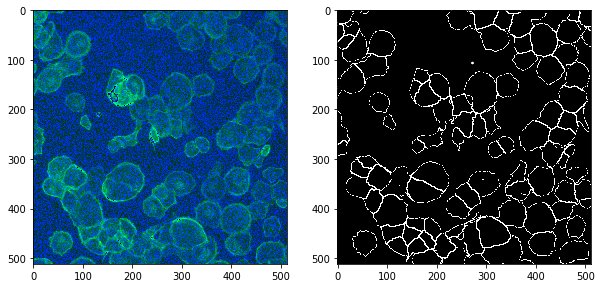

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = PIL.Image.open('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = PIL.Image.open('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

In [3]:
np.unique(mask)

array([  0,   1,   2,   8,   9,  35,  54,  80, 201, 202, 239, 240, 255],
      dtype=uint8)

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [10]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

# Solution

I just used pretrained [milesial/Pytorch-UNet](https://github.com/milesial/Pytorch-UNet)
which was somewhere in the top of the google's output for "pytorch pretrained unet".
Unfortunately this package depends on [pydensecrf](https://github.com/lucasb-eyer/pydensecrf)
which I don't care much about but it sometimes fails to build and install.
Worked fine on colab. Dependencies can be install by running `make`.

I've set up some environment for running experiments,
based on `sacred` for dependency injection and persistence
(including saving metrics, configs, and copies of exact source code),
`tensorboardX` for metrics.
Also used `ignite` to set up train loop, but I regret very much -- it got one of the
poorest designs I've ever seen, deeply intermixing logic and IO,
sprinkling callbacks (receiving global state!)
all over the place and randomly introducing implicit output transforms.

From my experiments I've found out:

0. One shouldn't (in this problem) freeze intermediate weights. I tried at first freezing everything except couple layers in the head and couple layers in the tail.
1. One shoudln't (in this problem) reset non-frozen weights (nor frozen neither, obviously). At first, I thought it'd be easier for the network to learn the first "thin" layer so that it reproduces old problem's distribution for the deeper layers. And it even seemed profitable, metrics-wise, but only because I've been freezing intermediate layers.
2. One shouldn't random-translate too much (in haste, I've at first allowed translating by 100% of the image, feeding empty array into the network).
3. One shouldn't crop too much (`64x64` makes it hard for network to learn anything, while `150x150` works just fine).
4. One shouldn't waste time on colab (had to restart most of the experiments many times because of disconnects and way too long wait times; extremely unhealthy environment for experiments). Instead, one should rent a V100 on vast.ai and spend minutes instead of hours (which turn into days because of unfinished experiments).

In [ ]:
! python setup.py develop
! conda install -c conda-forge Pydensecrf # because pip may fail with wrong gcc version
! yes | make

running develop
running egg_info
writing sktdl_hw3.egg-info/PKG-INFO
writing dependency_links to sktdl_hw3.egg-info/dependency_links.txt
writing top-level names to sktdl_hw3.egg-info/top_level.txt
package init file 'pytorch_unet/__init__.py' not found (or not a regular file)
reading manifest file 'sktdl_hw3.egg-info/SOURCES.txt'
writing manifest file 'sktdl_hw3.egg-info/SOURCES.txt'
running build_ext
Creating /home/nk/.conda/lib/python3.6/site-packages/sktdl-hw3.egg-link (link to .)
sktdl-hw3 0.0.0 is already the active version in easy-install.pth

Installed /home/nk/Notebooks/newkozlukov/skt_deeplearning/HW3
Processing dependencies for sktdl-hw3==0.0.0
Finished processing dependencies for sktdl-hw3==0.0.0
Solving environment: done

# All requested packages already installed.

[[ -d ../.git ]] && \
	git pull && \
	git submodule update
The authenticity of host 'github.com (140.82.118.4)' can't be established.
RSA key fingerprint is SHA256:nThbg6kXUpJWGl7E1IGOCspRomTxdCARLviKw6E5SY8.
Are

In [7]:
%load_ext tensorboard.notebook
%tensorboard --logdir sktdl_cells/unet_reset_runs